In [4]:
import os 
import tensorflow as tf
from tensorflow import experimental
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import torch
import torch.utils as utils
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm_notebook
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# Google Colab Pro were used for training: Hardware Accelerator: GPU, Runtime Shape: High-RAM
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/Public Folder: SafeGraph Group /Safegraph Data/Summary"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.chdir(f"{root_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


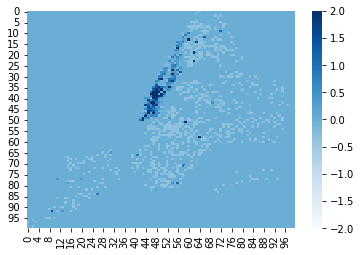

In [14]:
features = np.load('feature_100*100_sum.npy')
visits_ex = features[0,:,:,-1]
sns.heatmap(visits_ex, vmin = -2, vmax = 2, cmap="Blues")

In [15]:
def get_features(time_step,feature_matrix):
  features=np.zeros((feature_matrix.shape[0]-time_step, feature_matrix.shape[1], feature_matrix.shape[2], feature_matrix.shape[3]*time_step))
  results=np.zeros((feature_matrix.shape[0]-time_step, feature_matrix.shape[1], feature_matrix.shape[2]))
  for i in range(feature_matrix.shape[0]-time_step):
    features[i]=feature_matrix[i:i+time_step,:,:,:].reshape(1, feature_matrix.shape[1], feature_matrix.shape[2], feature_matrix.shape[3]*time_step)
    results[i]=feature_matrix[i+time_step,:,:,3]
  features=torch.tensor(features.astype(np.float32))
  results=torch.tensor(results.astype(np.float32))
  return features, results
time_step = 5
features, results=get_features(time_step, features)
train_idx = int(0.8*features.shape[0])
train_feature, train_result = features[:train_idx,:,:],results[:train_idx,:,:]
test_feature, test_result = features[train_idx:,:,:],results[train_idx:,:,:]

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(4 * time_step, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.BatchNorm2d(1, 0.8),
        )

    def forward(self, x):
        x = x.view(x.shape[0], x.shape[3], x.shape[1], x.shape[2])#(15, 20, 30, 30)
        x = F.sigmoid(self.conv_blocks(x))
        return x

In [17]:
model = CNN()
loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)
min_val_loss = np.inf
epochs = 10000
mean = np.zeros((epochs,2))
for epoch in tqdm_notebook(range(1,epochs + 1)):
    y_test = model(test_feature)
    y_test = y_test.view(y_test.shape[0], y_test.shape[2], y_test.shape[3])
    for i in range(y_test.shape[0]):
      y_test[i][features[0,:,:,0] == 0] = 0
    test_loss = loss(y_test, test_result)
    y_pred = model(train_feature)
    y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[2], y_pred.shape[3])
    l = loss(y_pred,train_result)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    train_loss, test_loss=l.detach().numpy(), test_loss.detach().numpy()
    mean[epoch-1,0]=train_loss.mean()
    mean[epoch-1,1]=test_loss.mean()
    if train_loss < min_val_loss:
      min_val_loss = train_loss
    print('Epoch: {:03d} | Lr: {:.20f} |Train loss: {:.8f}|Test loss: {:.8f}'.\
          format(epoch, optimizer.param_groups[0]['lr'], min_val_loss, test_loss.mean()))

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: 5001 | Lr: 0.00100000000000000002 |Train loss: 0.08326794|Test loss: 0.09998080
Epoch: 5002 | Lr: 0.00100000000000000002 |Train loss: 0.08326486|Test loss: 0.09998059
Epoch: 5003 | Lr: 0.00100000000000000002 |Train loss: 0.08326174|Test loss: 0.09997983
Epoch: 5004 | Lr: 0.00100000000000000002 |Train loss: 0.08325871|Test loss: 0.09997913
Epoch: 5005 | Lr: 0.00100000000000000002 |Train loss: 0.08325555|Test loss: 0.09997945
Epoch: 5006 | Lr: 0.00100000000000000002 |Train loss: 0.08325247|Test loss: 0.09997953
Epoch: 5007 | Lr: 0.00100000000000000002 |Train loss: 0.08324937|Test loss: 0.09997912
Epoch: 5008 | Lr: 0.00100000000000000002 |Train loss: 0.08324631|Test loss: 0.09997834
Epoch: 5009 | Lr: 0.00100000000000000002 |Train loss: 0.08324321|Test loss: 0.09997843
Epoch: 5010 | Lr: 0.00100000000000000002 |Train loss: 0.08324014|Test loss: 0.09997828
Epoch: 5011 | Lr: 0.00100000000000000002 |Train loss: 0.08323704|Test loss: 0.09997772
Epoch: 5012 | Lr

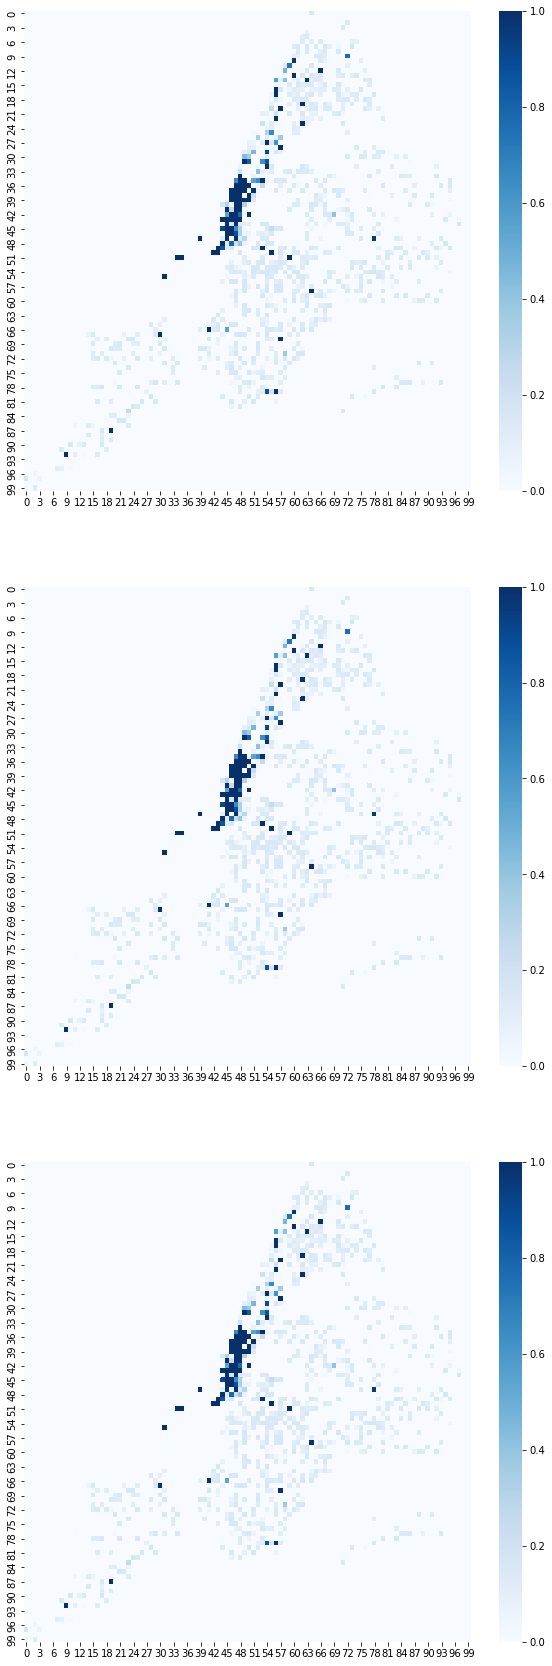

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(10,30)) 
for i in range(y_test.shape[0]):
  pred = y_test[0]
  true = test_result[0]
  Loss = (pred - true)**2
  sns.heatmap(Loss.detach().numpy(), vmin = 0, vmax = 1, cmap="Blues", ax = ax[i])